In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_pos'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4489795918367347 

Using scikit learn accuracy por género en el conjunto about
MALE 0.2109375
FEMALE 0.6775 

GLOBAL: 0.4696969696969697 

Using scikit learn accuracy por género en el conjunto to
MALE 0.24330900243309003
FEMALE 0.7139107611548556 

GLOBAL: 0.5071707953063885 

Using scikit learn accuracy por género en el conjunto as
MALE 0.25
FEMALE 0.7816711590296496 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6879108034152187 	 Validation loss: 0.6854242783481792 	 
  1%|          | 574/57400 [00:05<08:05, 116.96it/s]
Epoch 2 	 Training loss: 0.6827349537133339 	 Validation loss: 0.6836547730332714 	 
  2%|▏         | 1148/57400 [00:10<07:52, 119.01it/s]
Epoch 3 	 Training loss: 0.6813175287811598 	 Validation loss: 0.6833516662403688 	 
  3%|▎         | 1722/57400 [00:15<07:55, 117.17it/s]
Epoch 4 	 Training loss: 0.6809811109242123 	 Validation loss: 0.6830861548245963 	 
  4%|▍         | 2296/57400 [00:21<07:38, 120.27it/s]
Epoch 5 	 Training loss: 0.6808688378915554 	 Validation loss: 0.6831996865191702 	 
  5%|▌         | 2870/57400 [00:26<07:48, 116.27it/s]
Epoch 6 	 Training loss: 0.680769051305093 	 Validation loss: 0.6831594877323862 	 
  6%|▌         | 3444/57400 [00:31<07:28, 120.21it/s]
Epoch 7 	 Training loss: 0.6807865979156428 	 Validation loss: 0.6833553637488413 	 
  7%|▋         | 4018/57400 [00:36<07:25, 119.72it/s]
Epoch 8 	 Training loss: 0.68

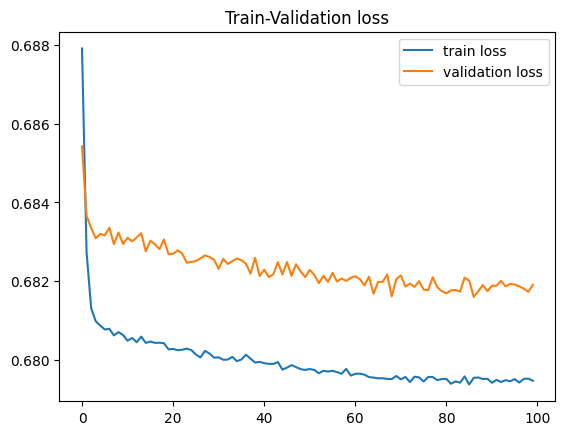

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4885204081632653 

Using scikit learn accuracy por género en el conjunto about
MALE 0.9973958333333334
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_pos'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934609583445958 	 Validation loss: 0.6928020695508537 	 
  1%|          | 574/57400 [00:05<08:51, 106.88it/s]
Epoch 2 	 Training loss: 0.6934016726988949 	 Validation loss: 0.6923870666552399 	 
  2%|▏         | 1148/57400 [00:11<08:40, 108.13it/s]
Epoch 3 	 Training loss: 0.693212132005326 	 Validation loss: 0.6927675857382306 	 
  3%|▎         | 1722/57400 [00:17<08:34, 108.14it/s]
Epoch 4 	 Training loss: 0.6932218680190708 	 Validation loss: 0.6926624249603789 	 
  4%|▍         | 2296/57400 [00:23<08:54, 103.17it/s]
Epoch 5 	 Training loss: 0.6933017670069838 	 Validation loss: 0.6928169434353456 	 
  5%|▌         | 2870/57400 [00:29<08:21, 108.70it/s]
Epoch 6 	 Training loss: 0.6932817355888646 	 Validation loss: 0.6927790692297079 	 
  6%|▌         | 3444/57400 [00:35<08:25, 106.64it/s]
Epoch 7 	 Training loss: 0.6932093713964734 	 Validation loss: 0.6926874124397666 	 
  7%|▋         | 4018/57400 [00:40<08:11, 108.70it/s]
Epoch 8 	 Training loss: 0.69

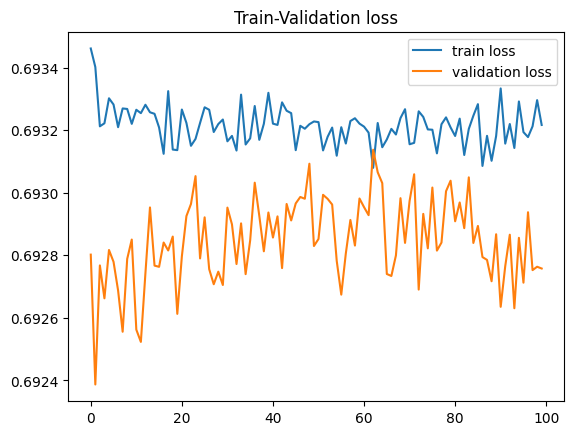

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5038265306122449 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4869791666666667
FEMALE 0.52 

GLOBAL: 0.4772727272727273 

Using scikit learn accuracy por género en el conjunto to
MALE 0.4209245742092457
FEMALE 0.5380577427821522 

GLOBAL: 0.4706649282920469 

Using scikit learn accuracy por género en el conjunto as
MALE 0.45454545454545453
FEMALE 0.48787061994609165 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_pos'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938981104395531 	 Validation loss: 0.6913215629125046 	 
  1%|          | 574/57400 [00:05<08:56, 106.00it/s]
Epoch 2 	 Training loss: 0.6934441984322843 	 Validation loss: 0.6925488377021531 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:45, 107.10it/s]
Epoch 3 	 Training loss: 0.6932253645479887 	 Validation loss: 0.6926007412247739 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:31, 108.78it/s]
Epoch 4 	 Training loss: 0.6933105591074515 	 Validation loss: 0.6928780685036869 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:23<08:31, 107.70it/s]
Epoch 5 	 Training loss: 0.6932774200672056 	 Validation loss: 0.6928608558945737 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:29<08:22, 108.56it/s]
Epoch 6 	 Training loss: 0.6933343777050125 	 Validation loss: 0.6929889674914085 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:34<08:13, 109.33it/s]
Epoch 7 	 Training los

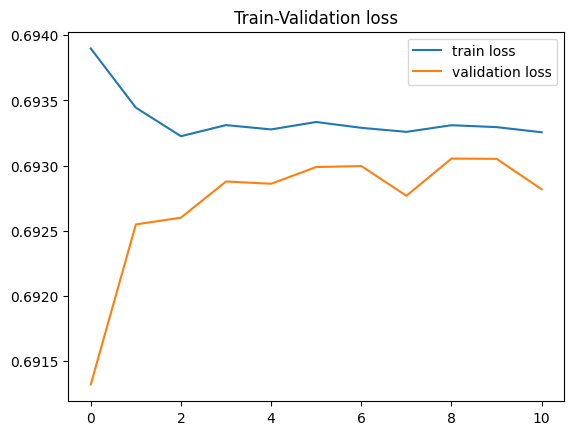

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5089285714285714 

Using scikit learn accuracy por género en el conjunto about
MALE 0.013020833333333334
FEMALE 0.985 

GLOBAL: 0.4797979797979798 

Using scikit learn accuracy por género en el conjunto to
MALE 0.014598540145985401
FEMALE 0.9816272965879265 

GLOBAL: 0.4954367666232073 

Using scikit learn accuracy por género en el conjunto as
MALE 0.03787878787878788
FEMALE 0.9838274932614556 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_pos_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.67954198252864 	 Validation loss: 0.6787761368993985 	 
  1%|          | 574/57400 [00:05<08:54, 106.39it/s]
Epoch 2 	 Training loss: 0.6682873062971162 	 Validation loss: 0.6601400547108408 	 
  2%|▏         | 1148/57400 [00:12<08:59, 104.24it/s]
Epoch 3 	 Training loss: 0.6552147051183189 	 Validation loss: 0.6523500529386229 	 
  3%|▎         | 1722/57400 [00:18<08:38, 107.32it/s]
Epoch 4 	 Training loss: 0.6471946480382195 	 Validation loss: 0.645092393382121 	 
  4%|▍         | 2296/57400 [00:23<08:49, 104.06it/s]
Epoch 5 	 Training loss: 0.6390789764891103 	 Validation loss: 0.6379780031866946 	 
  5%|▌         | 2870/57400 [00:29<08:33, 106.30it/s]
Epoch 6 	 Training loss: 0.6309932657235175 	 Validation loss: 0.6320751784211498 	 
  6%|▌         | 3444/57400 [00:35<08:32, 105.23it/s]
Epoch 7 	 Training loss: 0.6230762010044337 	 Validation loss: 0.6258973277221291 	 
  7%|▋         | 4018/57400 [00:41<08:38, 102.88it/s]
Epoch 8 	 Training loss: 0.6154

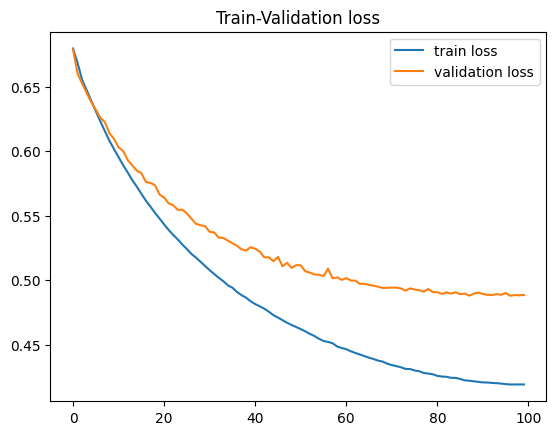

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7155612244897959 

Using scikit learn accuracy por género en el conjunto about
MALE 0.796875
FEMALE 0.6375 

GLOBAL: 0.5909090909090909 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6861313868613139
FEMALE 0.4881889763779528 

GLOBAL: 0.6271186440677966 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6818181818181818
FEMALE 0.568733153638814 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_pos_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934005770741439 	 Validation loss: 0.6920639811936071 	 
  1%|          | 574/57400 [00:06<09:56, 95.26it/s]
Epoch 2 	 Training loss: 0.693267956531837 	 Validation loss: 0.6927364347344738 	 
  2%|▏         | 1148/57400 [00:13<10:11, 92.06it/s]
Epoch 3 	 Training loss: 0.6932347021244128 	 Validation loss: 0.692758172245349 	 
  3%|▎         | 1722/57400 [00:20<10:41, 86.82it/s]
Epoch 4 	 Training loss: 0.6931902899144003 	 Validation loss: 0.693846578315153 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:28<11:59, 76.60it/s]
Epoch 5 	 Training loss: 0.6931809137091819 	 Validation loss: 0.6934914700055527 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:36<12:39, 71.84it/s]
Epoch 6 	 Training loss: 0.6932119429111481 	 Validation loss: 0.6943846243922993 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:44<11:44, 76.56it/s]
Epoch 7 	 Training loss: 0.6931199824976173 	 Validation loss: 0.6931143382848319 	 

4 e

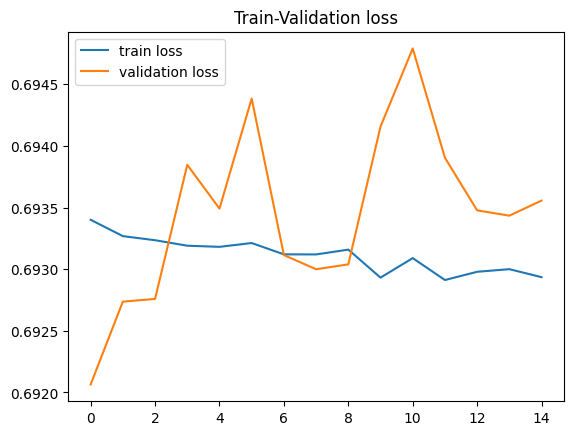

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5153061224489796 

Using scikit learn accuracy por género en el conjunto about
MALE 0.010416666666666666
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0024330900243309003
FEMALE 0.9973753280839895 

GLOBAL: 0.485006518904824 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0025252525252525255
FEMALE 1.0 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_pos_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933755742755916 	 Validation loss: 0.6928721171314434 	 
  1%|          | 574/57400 [00:08<13:25, 70.54it/s]
Epoch 2 	 Training loss: 0.6932640681075718 	 Validation loss: 0.6928431533150754 	 
  2%|▏         | 1148/57400 [00:16<12:18, 76.19it/s]
Epoch 3 	 Training loss: 0.693136794330351 	 Validation loss: 0.6928424370490899 	 
  3%|▎         | 1722/57400 [00:24<12:10, 76.18it/s]
Epoch 4 	 Training loss: 0.6931165245974936 	 Validation loss: 0.6943143444546198 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:33<12:10, 75.43it/s]
Epoch 5 	 Training loss: 0.6931026829244368 	 Validation loss: 0.6928970692521434 	 
  5%|▌         | 2870/57400 [00:41<12:01, 75.56it/s]
Epoch 6 	 Training loss: 0.6930821461129272 	 Validation loss: 0.6937464061429945 	 
  6%|▌         | 3444/57400 [00:49<12:03, 74.55it/s]
Epoch 7 	 Training loss: 0.6930661615802021 	 Validation loss: 0.6923366178900509 	 
  7%|▋         | 4018/57400 [00:57<11:54, 74.68it/s]
Epoch 8

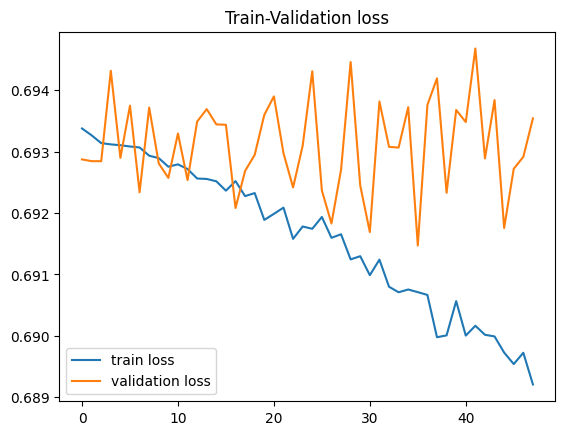

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4770408163265306 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4791666666666667
FEMALE 0.475 

GLOBAL: 0.51010101010101 

Using scikit learn accuracy por género en el conjunto to
MALE 0.5450121654501217
FEMALE 0.47244094488188976 

GLOBAL: 0.5501955671447197 

Using scikit learn accuracy por género en el conjunto as
MALE 0.5757575757575758
FEMALE 0.522911051212938 

